# Amazon Shipping Review Sentiment Analysis

# Imports

In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPool2D, Bidirectional, LSTM, Embedding
import tensorflow as tf

# Functions

In [26]:
def check_for_nulls_dupes(df):
  print(f"The Amount of Null Values: {df.isna().sum()}")
  print(f"The Amount of Duplicated Values: {df.duplicated().sum()}")

def check_class_balance(target):
  
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(10, 7))
  plt.title("Target Class Breakdown")
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.show()
  
  plt.figure(figsize=(10, 7))
  plt.title("Target Class Breakdown")
  sns.countplot(x=target)
  plt.xlabel("Target Classes")
  plt.ylabel("Counts")
  plt.show()

def remove_stop_words(review):
  
  word_tokens = " ".join(word_tokenize(review))
  
  filtered_word_tokens = re.sub(r'[^a-zA-Z\s]', "", word_tokens).split(" ")
  filtered_sentence = [w.lower().strip() for w in filtered_word_tokens if not w.lower() in ENGLISH_STOP_WORDS]
  return " ".join(filtered_sentence).strip()

# EDA Analysis

In [27]:
df = pd.read_csv("/Users/maukanmir/Downloads/amazon_reviews.csv", nrows=10000)
df

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,2bbdf21c-884f-4483-9a91-5c1fae8f21e0,Ranoldo Robinson,I don't like how I only got the money back fro...,1,0,28.10.0.100,2024-05-29 22:18:33,28.10.0.100
1,b828f749-86a3-4582-b5a2-fa18e10b0065,Sarah Gamal,اوحش شركة ممكن تتعامل معاها علي الاطلاق وحرامي...,1,0,28.10.0.100,2024-05-29 22:17:51,28.10.0.100
2,75ce884e-4e72-4c4f-8073-cc674d9c6171,khadiga,Free phalastine,1,0,NaN,2024-05-29 21:49:36,NaN
3,232f979d-115a-4348-b6e4-38e3e7799324,Shr Ashrf,Soooo baaaad,1,0,NaN,2024-05-29 21:40:36,NaN
4,bee9bbeb-50d8-4cd5-a907-fa944d6dba6f,Alberto Sandoval,AMAZINGGGGG!,5,0,28.10.0.100,2024-05-29 21:02:53,28.10.0.100
...,...,...,...,...,...,...,...,...
9995,022648f2-defc-4bc7-b499-bf08cd1281d2,A Google user,it's a great game and I've had no issues so fa...,5,2,NaN,2018-11-13 19:15:26,NaN
9996,bd44b683-8799-40a2-a979-1f03de29bac4,Christy Marvin,I gave this a one star because prior to the up...,1,19,22.16.0.100,2021-08-23 10:58:04,22.16.0.100
9997,d1e7edb3-a1d2-4e91-a63e-f5b82b6b7f11,A Google user,Would be 5 stars but the new update isn't that...,1,36,18.16.2.100,2019-09-02 03:40:57,18.16.2.100
9998,960bf6cd-5a2e-4811-9064-585685fa3ab6,A Google user,Newest update is garbage. I don't usually writ...,1,3,NaN,2019-10-02 01:22:23,NaN


# Check for Nulls and Dupes

In [28]:
check_for_nulls_dupes(df)

The Amount of Null Values: reviewId                  0
userName                  1
content                   2
score                     0
thumbsUpCount             0
reviewCreatedVersion    733
at                        0
appVersion              733
dtype: int64
The Amount of Duplicated Values: 114


In [29]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [30]:
df.shape

(9167, 8)

# Check Class Imbalance

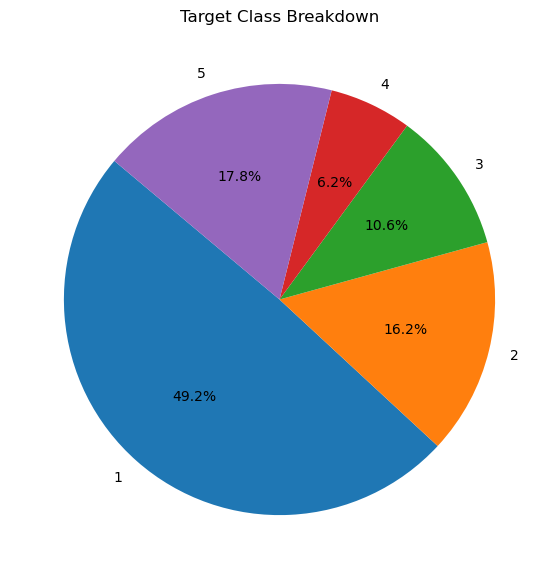

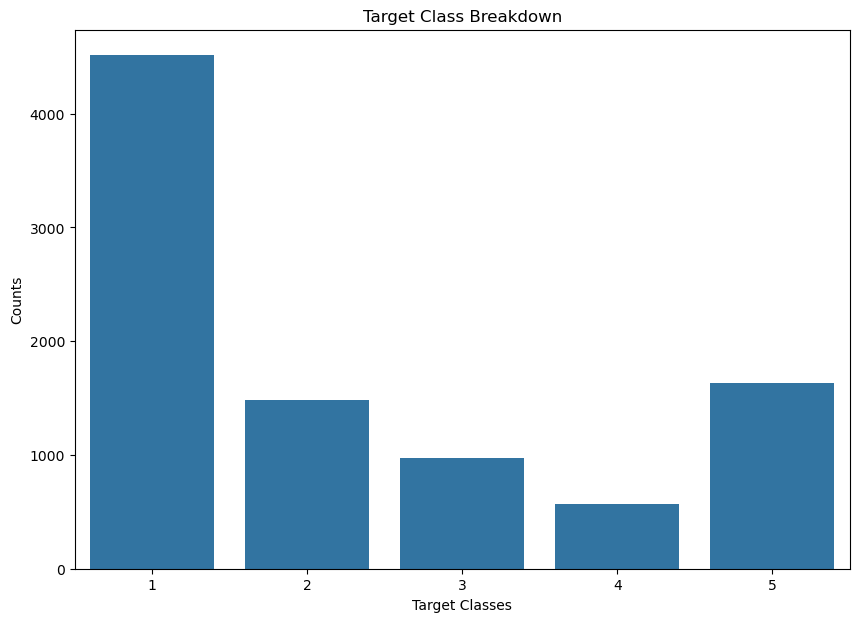

In [31]:
check_class_balance(df["score"])

# Signficant Class Imbalance Exists

In [32]:
df.describe()

,score,thumbsUpCount
count,9167.000000,9167.000000
mean,2.271299,45.376677
std,1.540432,174.465427
min,1.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,1.000000
75%,3.000000,18.000000
max,5.000000,5660.000000


# Drop Useless Columns

In [33]:
df = df.drop(['reviewId', 'userName','reviewCreatedVersion', 'appVersion'], axis=1)

# Data Preprocessing

In [34]:
df["content"] = df["content"].apply(remove_stop_words)
df["at"] = pd.to_datetime(df["at"])

df["day"] = df["at"].dt.day
df["hour"] = df["at"].dt.hour
df["year"] = df["at"].dt.year
df["month"] = df["at"].dt.month

# Our Dataset had reviews in another language. So we can remove them now that we turned them into empty strings like so:

In [35]:
df[df["content"]== ""]

,content,score,thumbsUpCount,at,day,hour,year,month
1,,1,0,2024-05-29 22:17:51,29,22,2024,5
35,,1,0,2024-05-29 15:11:47,29,15,2024,5
87,,5,0,2024-05-29 02:31:49,29,2,2024,5
109,,1,0,2024-05-28 21:17:56,28,21,2024,5
176,,5,0,2024-05-28 02:53:19,28,2,2024,5
237,,5,0,2024-05-27 14:32:46,27,14,2024,5
246,,1,0,2024-05-27 12:44:44,27,12,2024,5
283,,2,0,2024-05-26 21:17:58,26,21,2024,5
297,,5,0,2024-05-26 19:08:04,26,19,2024,5
366,,1,0,2024-05-26 04:26:14,26,4,2024,5


In [36]:
df = df[df["content"].str.strip() != ""]

In [37]:
df.shape

(9136, 8)

In [38]:
df = df.drop("at", axis=1)

In [41]:
df["len_review"] = df["content"].apply(lambda content: len(content))
df["word_count"] = df["content"].apply(lambda content: len(content.split(" ")))

# Visuals

<AxesSubplot:xlabel='score', ylabel='thumbsUpCount'>

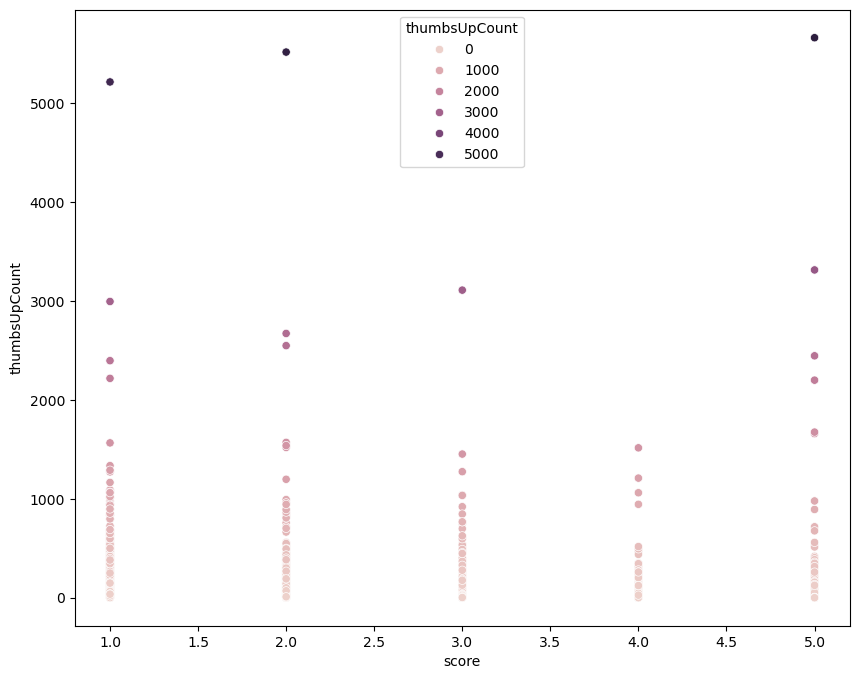

In [40]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x="score", y="thumbsUpCount", hue="thumbsUpCount")

<AxesSubplot:xlabel='score', ylabel='len_review'>

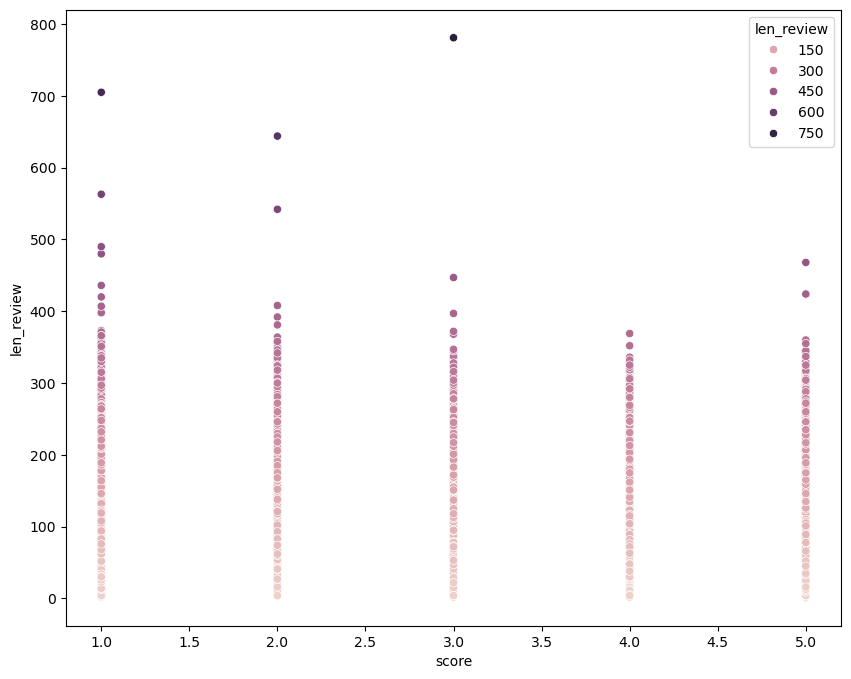

In [42]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x="score", y="len_review", hue="len_review")

<AxesSubplot:xlabel='score', ylabel='word_count'>

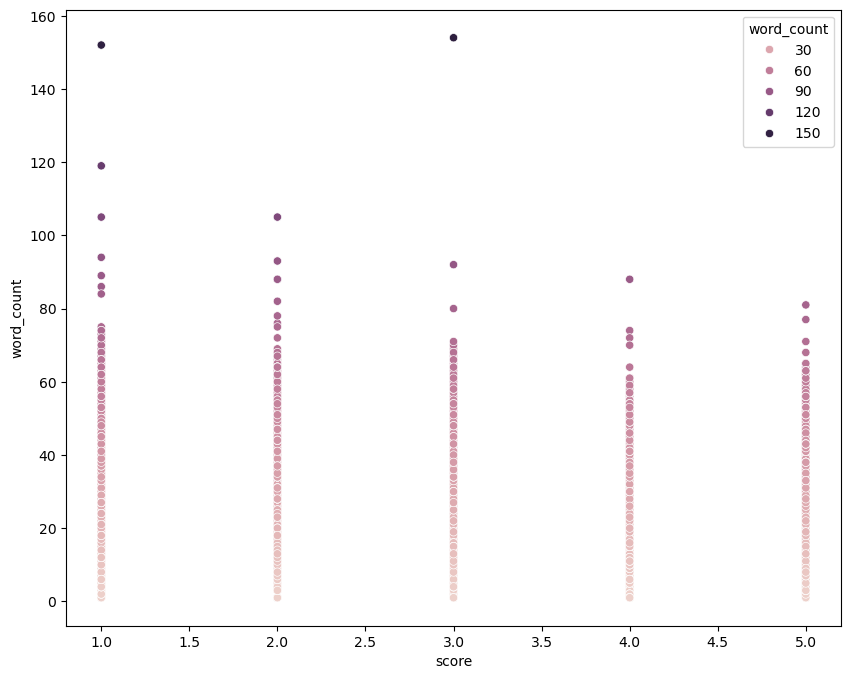

In [43]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x="score", y="word_count", hue="word_count")

# Separate Features

In [44]:
X, y = df["content"], df["score"]

# Bert Model

In [46]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [49]:
model = Sequential()
vocab_size = len(tokenizer.get_added_vocab())+1
model.add(Embedding(input_dim=vocab_size, output_dim=32))
model.add(Bidirectional(LSTM(32, activation="tanh")))
model.add(Dense(128, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(512, activation="relu"))
model.add(Dense(5, activation="softmax"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          192       
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 dense_3 (Dense)             (None, 5)                 2565      
                                                      

In [51]:
seq = [sequence for sequence in X]
model_inpus = tokenizer(seq, padding=True, return_tensors="tf")